In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [83]:
class Signal:

    def __init__(self) -> None:
        pass

    def signal_initialize(self, amplitude, frequency, reprtition, n_points, duty_cycle):
        self.amplitude = amplitude
        self.frequency = frequency
        self.reprtition = reprtition
        self.n_points = n_points
        self.duty_cycle = duty_cycle
        self.period = 1 / frequency
        self.time_array = np.linspace(0, self.reprtition * self.period, self.reprtition * self.n_points)

    def sine(self) -> list:
        scale = 2 * np.pi * self.frequency
        voltage = self.amplitude * np.sin(self.time_array * scale)
        self.V = np.array(voltage)
        return [self.time_array, self.V]
    
    def triangle(self):
        quater_period = self.period / 4
        t = self.time_array
        voltage = []
        for j in range(self.reprtition):
            for i in t[j * self.n_points: (j+1) * self.n_points]:
                if i <= (t[j * self.n_points] + quater_period):
                    voltage.append(self.amplitude / quater_period * (i - t[j * self.n_points])+ np.random.normal(0,0.05))
                elif (i > (t[j * self.n_points] + quater_period)) and (i < (t[j * self.n_points] + 3 * quater_period)):
                    voltage.append(- self.amplitude / quater_period * (i - t[j * self.n_points] - 3 * quater_period) - self.amplitude+ np.random.normal(0,0.05))
                elif i > (t[j * self.n_points] + 3 * quater_period):
                    voltage.append(self.amplitude / quater_period * (i - t[j * self.n_points]) - 4 * self.amplitude+ np.random.normal(0,0.05))
        self.V = np.array(voltage)
        return [self.time_array, self.V]
    
    def bipolar_rectangle(self):
        half_period = self.period / 2
        t = self.time_array
        voltage = []
        for j in range(self.reprtition):
            for i in t[j * self.n_points: (j+1) * self.n_points]:
                if (i <= (t[j * self.n_points] + half_period/2)) or ((i > (t[j * self.n_points] + half_period)) and i < (t[j * self.n_points] + 3/2 *half_period)):
                    voltage.append( 0)
                elif (i > (t[j * self.n_points] + half_period/2)) and i < (t[j * self.n_points] + half_period):
                    voltage.append(self.amplitude)
                elif (i > (t[j * self.n_points] + 3/2 *half_period)):
                    voltage.append(- self.amplitude)
        voltage[-1] = 0
        self.V = np.array(voltage)
        return [self.time_array, self.V]



In [84]:
class Hyperparameters:

    def __init__(self) -> None:
        pass

    def hyp_initialize(self, V_th_n, V_th_p, a, b, c, s, n, beta, xi, alpha_m, gamma):
        self.V_th_p = np.random.normal(V_th_p,0.25)
        self.V_th_n = np.random.normal(V_th_n,0.25)
        self.a = a
        self.b = b
        self.c = c
        self.s = s
        self.n = n
        self.beta = beta
        self.xi = xi
        self.alpha_m = alpha_m
        self.gamma = gamma

In [85]:
class Calculation:

    def __init__(self) -> None:
        pass
    
    def p_calc(self, V_i):
        return int(self.b/(np.abs(V_i) + self.c))

    def f_calc(self, x_i, V_i):
        if V_i <= - self.V_th_n:
            return 1 - (1 - x_i) ** (self.p_calc(V_i))
        elif V_i >= self.V_th_p:
            return 1 - x_i ** (self.p_calc(V_i))
        else:
            return 0
        
    def x_calc(self):
        delta_t = self.time_array[1] - self.time_array[0]
        x = [0]
        for i in range(1, len(self.time_array)):
            x.append(self.a * self.V[i-1] ** self.s * self.f_calc(x[i-1], self.V[i-1]) * delta_t + x[i-1])
        return np.array(x)

    def current_calc(self):
        x = self.x_calc()
        return x ** self.n * self.beta * np.sinh(self.alpha_m * self.V) + self.xi * (np.exp(self.gamma * self.V) - 1)
    
    def current_calc_with_noise(self):
        x = self.x_calc()
        I = x ** self.n * self.beta * np.sinh(self.alpha_m * self.V) + self.xi * (np.exp(self.gamma * self.V) - 1)
        I_plus_noise = np.array([i * (1 + np.random.normal(0,0.1)) for i in I])
        return I_plus_noise

In [86]:
class Model(Signal, Hyperparameters, Calculation):

    amplitude: float 

    def __init__(self) -> None:
        super().__init__()

    def set_puls_params(self, amplitude = 2, frequency = 1, reprtition = 1, n_points = 100, duty_cycle = 0.25):
        super().signal_initialize(amplitude= amplitude, frequency= frequency, reprtition = reprtition, n_points = n_points, duty_cycle = duty_cycle)

    def set_hyperparams(self, V_th_p  = 1.5, V_th_n  = 1.5, a= 1 , b = 15, c = 2, s = 5, n = 5, beta = 7.069 * 10 ** (-5), xi = 1.946 * 10 ** (-4), alpha_m = 1.8, gamma = 0.15):
        super().hyp_initialize(V_th_p = V_th_p, V_th_n = V_th_n, a = a, b = b, c = c, s = s, n = n, beta = beta, xi = xi, alpha_m = alpha_m, gamma = gamma)
        
    def set_puls_form(self, puls_type = 'sine'):
        match puls_type:
            case 'sine':
                self.t, self.V = super().sine()
            case 'triangle':
                self.t, self.V = super().triangle()
            case 'rectangle':
                self.t, self.V = super().bipolar_rectangle()
            case _:
                self.t, self.V = super().sine()
                print('The pulse_type is\'t set correctly. The default pulse_type value is set')

    def set_default(self):
        self.set_hyperparams()
        self.set_puls_params()
        self.set_puls_form()

    def calculate(self, set_noise = False):
        if set_noise == True:
            self.I = super().current_calc_with_noise()
        else:
            self.I = super().current_calc()



"plt.yscale('log')\nplt.ylim([10**(-9),10**(-1)])"

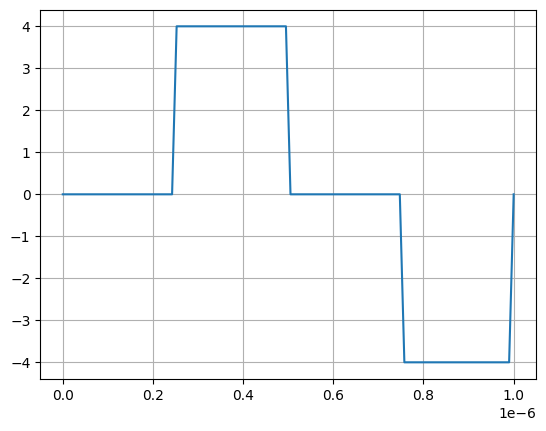

In [94]:
m = Model()

m.set_hyperparams(V_th_p=3, V_th_n = 2, a=100000, n=13, beta=10 ** (-3), xi=10**(-6), alpha_m=1)
m.set_puls_params(n_points=100, frequency=1000000, amplitude=4, reprtition=1, duty_cycle= 0.1)
m.set_puls_form(puls_type='rectangle')
m.calculate(set_noise=True)
t = m.time_array
V = m.V
I = m.I

#R = V/I


#plt.plot(V,np.abs(I), linewidth = 0.5)
plt.plot(t, V)
plt.grid()
'''plt.yscale('log')
plt.ylim([10**(-9),10**(-1)])'''


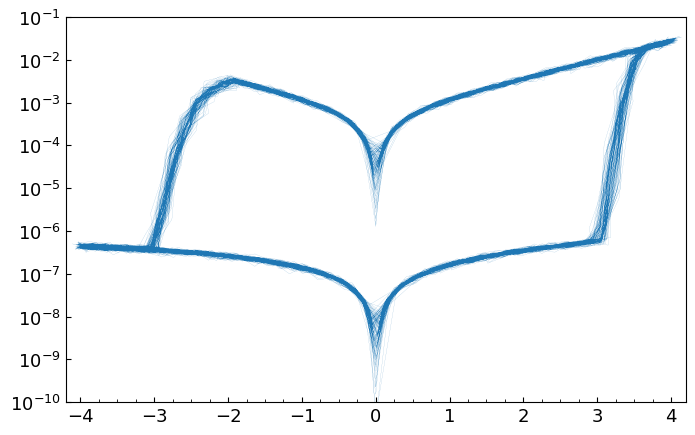

In [88]:
fig, ax = plt.subplots(figsize = [8, 5])

ax.plot(V,np.abs(I), linewidth = 0.07)
ax.set_ylim([10**(-10),10**(-1)])
ax.set_xlim([-4.2, 4.2])
ax.set_yscale('log')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax.tick_params(axis='x', which='both', labelsize=13, direction='in')
ax.tick_params(axis='y', labelsize=13, direction='in')
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=20))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))

#plt.savefig('I_V.png', dpi = 300, bbox_inches = 'tight')

### В следующий раз нужно делать модель уже с учетом того, что она будет моделироваться онлайн с учетом других элементов цепи

In [89]:
m_3 = Model()

m_3.set_default
m_3.calculate()
t = m_3.time_array
V = m_3.V
I = m_3.I

#R = V/I


plt.plot(V,(I), linewidth = 1)
#plt.plot(t, I)
plt.grid()
'''plt.yscale('log')
plt.ylim([10**(-9),10**(-1)])'''

AttributeError: 'Model' object has no attribute 'time_array'